## Imports

In [1]:
import torch
import os
import json
import sys
import pandapower as pp
import numpy as np
import julia
from torch.utils.data import DataLoader, TensorDataset
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

sys.path.append(os.path.abspath('../entrenamiento'))


from omegaconf import OmegaConf
# from find_best_run import find_best_run
from src.arquitecturas import GNNUnsupervised, FCNNUnsupervised
from src.Data_loader import load_net, load_data
from src.utils import get_Ybus, get_Yline, init_lamdas,get_line
from src.Loss import my_loss, get_max_min_values,cost_ploss, constraint_violation_power_flow




import warnings
warnings.filterwarnings('ignore')


[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4605 MHz      91993 s         22 s      12618 s   30768503 s          0 s
  Memory: 62.63290023803711 GB (49065.41015625 MB free)
  Uptime: 192982.04 sec
  Load Avg:  0.84  1.5  1.2
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/us

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90


## Levantar Mejor Red

In [2]:
red = "30" # "118" o "30"
arq = "GNN" # "GNN" o "FCNN"

# Levantar config y pesos del modelo
entrenamiento = "best"
cfg = OmegaConf.load(f"./runs/{red}/{arq}/" + entrenamiento + "/config.yaml")
weights_dir = f"./runs/{red}/{arq}/" + entrenamiento +  "/weights/best_model.pt"

# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
edge_index, edge_weights, net = load_net(cfg.data.red,cfg.data.red_path,device)

if red == "30":
    net.line["max_loading_percent"] *= 1.1
    net.ext_grid["min_q_mvar"] = -50
else:
    net.trafo.tap_pos = 0.0
    net.bus.max_vm_pu = 1.1
    net.bus.min_vm_pu = 0.9
    net.line.max_i_ka /= 20
pp.runpp(net)
Y_bus = get_Ybus(net,device)
Y_line = get_Yline(net,device)
line = get_line(net, device)
min_vector, max_vector = get_max_min_values(net,device)

# Set model
num_layers = len(cfg.model.layers) - 1
num_nodes = len(net.bus)
try:
    a = cfg.model.model
except:
    cfg.model.model = "GNN"
if cfg.model.model=="GNN":
        model = GNNUnsupervised(cfg.model.layers, edge_index, edge_weights, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,cfg.model.dropout, batch_norm=cfg.training.batch_norm, use_edge_weights=cfg.training.use_edge_weights).to(device)
elif cfg.model.model=="FCNN":
    cfg.model.K = -1
    model = FCNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes, cfg.model.dropout, batch_norm=cfg.training.batch_norm).to(device)
# Cargar datos

train_loader, val_loader, test_loader, norm_x = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.red, device)# train_loader, val_loader, test_loader = load_data(cfg.data.data_path, cfg.training.batch_size, False, cfg.data.red,device)
train_loader_unorm, val_loader_unorm, test_loader_unorm, _ = load_data(cfg.data.data_path, cfg.training.batch_size, False, cfg.data.red,device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model.load_state_dict(torch.load(weights_dir))
model.eval()

GNNUnsupervised(
  (convs): ModuleList(
    (0): TAGConv(3, 128, K=4)
    (1-2): 2 x TAGConv(128, 128, K=4)
    (3): TAGConv(128, 4, K=4)
  )
  (batchnorm): ModuleList(
    (0-2): 3 x BatchNorm(3840)
    (3): BatchNorm(120)
  )
  (dropout): Dropout(p=0.0011508237208871278, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [43]:
cfg

{'outdir': '../resultados/runs_ploss_final', 'model': {'model': 'GNN', 'layers': [3, 128, 128, 128, 4], 'K': [4, 4, 4, 4], 'dropout': 0.0011508237208871278}, 'data': {'data_path': '../data', 'red': '30', 'red_path': 'None', 'normalize_X': False}, 'training': {'device': 'cuda', 'batch_size': 32, 'lr': 0.0046974457489006695, 'num_epochs': 1500, 'early_stopping': 30, 'betas': [0.9, 0.999], 'weight_decay': 0.000166248242942314, 'seed': 42, 'initial_metric_epoch': 0, 'batch_norm': True, 'use_edge_weights': True, 'dual_coefs': [63.715274939554476, 62.89505707137162, 9.5229097994517e-06], 'node_weights': [1, 21, 26, 22, 12], 'alpha_node_weights': 0}}

## Predecir Salidas en Test

In [3]:
y_tensor_test = torch.Tensor(np.load(f'../data/red{red}/test/vm_pu_opt.npy')).to(device)
data_test = TensorDataset( y_tensor_test)
test_loader_Y = DataLoader(data_test, batch_size=cfg.training.batch_size,drop_last=True)
combined_dataloader = zip(test_loader, test_loader_Y)

u_pred = []
x_tot = []
y_tot = []
for input, y in combined_dataloader:
    u_pred.append(model(input[0]).detach().cpu().numpy())
    y_tot.append(y[0].detach().cpu().numpy())

for input in test_loader_unorm:
    x_tot.append(input[0].detach().cpu().numpy())

# Concatenate in dim 0
u_pred = np.concatenate(u_pred, axis=0)
y_pred = u_pred[:,:,2][:,:,None]
x_tot = np.concatenate(x_tot, axis=0)
y_tot = np.concatenate(y_tot, axis=0)
y_tot = y_tot[:,:,None]

### Graficas comparando voltajes óptimos y predichos

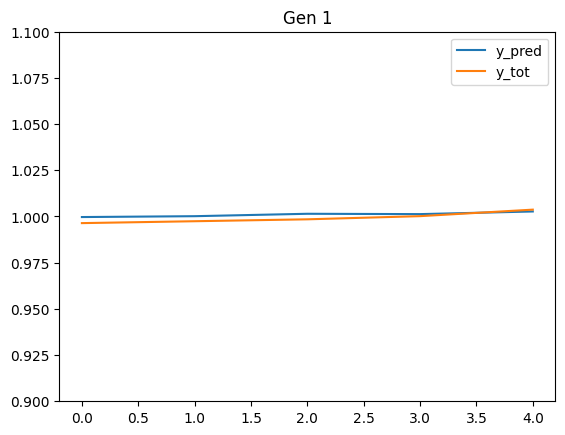

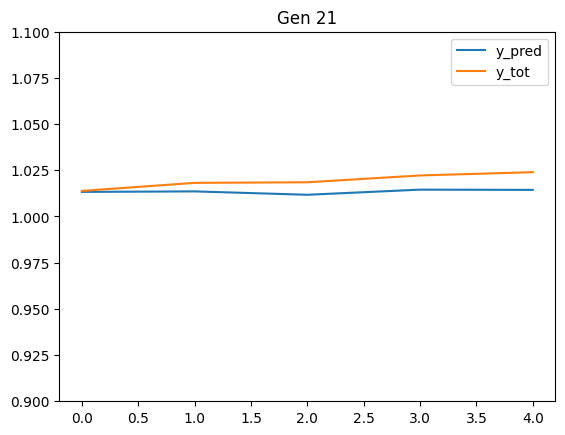

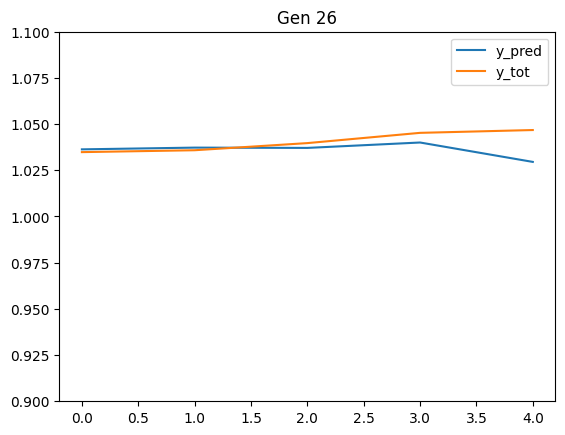

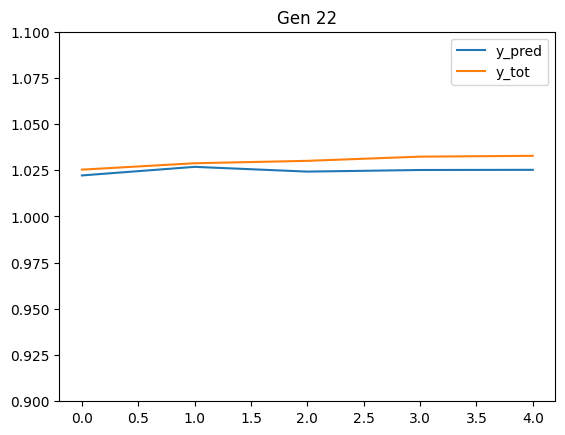

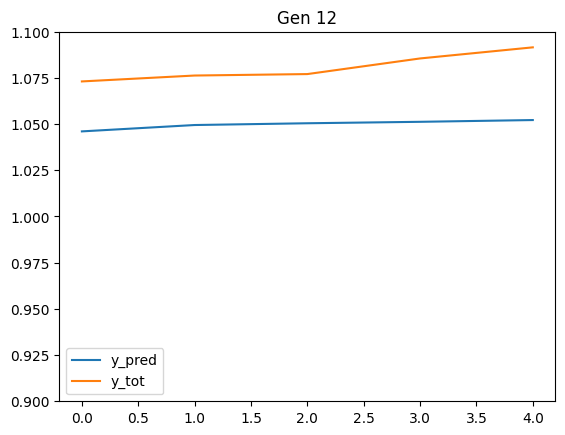

In [4]:
import matplotlib.pyplot as plt
idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
# Plot an histagram per gen of y_pred and y_tot
idx_anomalos = []
idx_promedio = []
for i in idx_gens:
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot[:,i].squeeze())
    y_tot_i = y_tot[idx,i].squeeze()
    y_pred_i = y_pred[idx,i].squeeze()
    idx_anomalos_i = np.hstack([idx[0:5],idx[-5:]])
    idx_anomalos.append(idx_anomalos_i)
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    # plt.plot([0,1,2,3,4,len(y_pred_i)-5,len(y_pred_i)-4,len(y_pred_i)-3,len(y_pred_i)-2,len(y_pred_i)-1], y_tot[idx_anomalos_i,i].squeeze(), "x")
    plt.title(f"Gen {i}")
    plt.ylim(0.9,1.1)
    plt.legend()
    plt.show()
idx_anomalos = np.array(idx_anomalos).reshape(-1)

## Evaluar desempeño como solucion del ORPD

### Función para evaluar pérdias y unfeasiblity

In [6]:
def get_stats(net,tol=2e-3, percent_gap=None):
    # METRICA
    Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
    Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
    V_mag = net.res_bus.vm_pu
    delta = net.res_bus.va_degree
    V = V_mag * np.exp(1j * delta * 2*np.pi/360)
    V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
    V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
    ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
    ploss_cost = ploss.sum()
    
    # v_cost = (np.abs(net.res_bus.vm_pu.values - 1)**2).sum()
    max_line = net.line.max_loading_percent.values.copy()
    if percent_gap is not None:
        max_line = max_line * (1 + percent_gap)
    unfeas_line = (net.res_line.loading_percent.values > max_line + tol).sum()
    gap_line_max = (net.res_line.loading_percent.values - net.line.max_loading_percent.values - tol)/(net.line.max_loading_percent.values - 0)
    gap_line_max = gap_line_max[np.where(gap_line_max > 0)] * 100
    # if unfeas_line > 0:
        # print(gap_line_max)
    #     print((net.res_line.loading_percent.values - net.line.max_loading_percent.values)[np.where(net.res_line.loading_percent.values > net.line.max_loading_percent.values)], net.line.max_loading_percent.values[np.where(net.res_line.loading_percent.values > net.line.max_loading_percent.values)])
    
    unfeas_trafo = 0
    gap_trafo_max = []
    if len(net.trafo) > 0:
        max_trafo = net.trafo.max_loading_percent.values.copy()
        if percent_gap is not None:
            max_trafo = max_trafo * (1 + percent_gap)
        unfeas_trafo = (net.res_trafo.loading_percent.values > max_trafo + tol).sum()
        gap_trafo_max = (net.res_trafo.loading_percent.values - net.trafo.max_loading_percent.values - tol)/(net.trafo.max_loading_percent.values - 0)
        gap_trafo_max = gap_trafo_max[np.where(gap_trafo_max > 0)] * 100
    else:
        unfeas_trafo = 0
    
    max_volt = net.bus.max_vm_pu.values.copy()
    min_volt = net.bus.min_vm_pu.values.copy()
    if percent_gap is not None:
        max_volt +=  percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        min_volt -= percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    unfeas_volt = (net.res_bus.vm_pu.values < min_volt - tol).sum() + (net.res_bus.vm_pu.values > max_volt + tol).sum()
    gap_volt_max = (net.res_bus.vm_pu.values - net.bus.max_vm_pu.values - tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_max = gap_volt_max[np.where(gap_volt_max > 0)] * 100
    gap_volt_min = (-net.res_bus.vm_pu.values + net.bus.min_vm_pu.values + tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_min = gap_volt_min[np.where(gap_volt_min > 0)] * 100
    
    
    max_q_extgrid = net.ext_grid.max_q_mvar.values.astype(float).copy()
    min_q_extgrid = net.ext_grid.min_q_mvar.values.astype(float).copy()
    if percent_gap is not None:
        max_q_extgrid +=  percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
        min_q_extgrid -= percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < min_q_extgrid - tol).sum() + (net.res_ext_grid.q_mvar.values > max_q_extgrid + tol).sum()
    gap_q_ext_grid_max = (net.res_ext_grid.q_mvar.values - net.ext_grid.max_q_mvar.values - tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_max = gap_q_ext_grid_max[np.where(gap_q_ext_grid_max > 0)] * 100
    gap_q_ext_grid_min = (-net.res_ext_grid.q_mvar.values + net.ext_grid.min_q_mvar.values + tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_min = gap_q_ext_grid_min[np.where(gap_q_ext_grid_min > 0)] * 100

    # append all gaps if there is a value
    gaps_percentages = []
    if len(gap_line_max) > 0:
        gaps_percentages += list(gap_line_max)
    if len(gap_trafo_max) > 0:
        gaps_percentages += list(gap_trafo_max)
    if len(gap_volt_max) > 0:
        gaps_percentages += list(gap_volt_max)
    if len(gap_volt_min) > 0:
        gaps_percentages += list(gap_volt_min)
    if len(gap_q_ext_grid_max) > 0:
        gaps_percentages += list(gap_q_ext_grid_max)
    if len(gap_q_ext_grid_min) > 0:
        gaps_percentages += list(gap_q_ext_grid_min)
        
    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
        unfeas = True
    else:
        unfeas = False
    return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid], gaps_percentages


### Ejecutar la función para datos de test

In [7]:
v_cost_hist = []
unf_hist = []
unf_cont_hist = []
gap_percentages_hist_pred = []
gap_percentages_hist_opt = []
gap_percentages_hist_v1 = []
# unfeas_idxs = []

percent_gap = 0.0

for idx in range(np.shape(x_tot)[0]):
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]* 100
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]* 100
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]* 100
    net.gen.vm_pu = y_pred[idx,idx_gens,0]
    
    pp.runpp(net, enforce_q_lims=True)
    # if idx in a:
        # print(net.res_bus.vm_pu.values[np.where(net.res_bus.vm_pu > 1.1)])
        # print(net.res_ext_grid.q_mvar.values[np.where(net.res_ext_grid.q_mvar < -300)])
    v_cost_pred, unf_pred, unf_const_pred, gaps_percentages_pred = get_stats(net,percent_gap=percent_gap)
    # if unf_pred:
    #     unfeas_idxs.append(idx)

    net.gen.vm_pu = 1
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1, gaps_percentages_v1  = get_stats(net,percent_gap=percent_gap)
    
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt, gaps_percentages_opt  = get_stats(net,percent_gap=percent_gap)
    
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])
    gap_percentages_hist_pred += gaps_percentages_pred
    gap_percentages_hist_opt += gaps_percentages_opt
    gap_percentages_hist_v1 += gaps_percentages_v1


v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

### Observar resultados

In [8]:
print(f"El porcentaje de factibles para el óptimo es: {1 - unf_hist[:,1].mean(axis=0)}")
print(f"El porcentaje de factibles para la predicción es: {1 - unf_hist[:,0].mean(axis=0)}")
print(f"El porcentaje de factibles para el naive es: {1 - unf_hist[:,2].mean(axis=0)}")

El porcentaje de factibles para el óptimo es: 0.8
El porcentaje de factibles para la predicción es: 0.8
El porcentaje de factibles para el naive es: 0.8


In [9]:
print(f"El costo promedio para el óptimo es: {v_cost_hist[:,1].mean(axis=0)}")	
print(f"El costo promedio para la predicción es: {v_cost_hist[:,0].mean(axis=0)}")
print(f"El costo promedio para el naive es: {v_cost_hist[:,2].mean(axis=0)}")


El costo promedio para el óptimo es: 2.5475801386558365
El costo promedio para la predicción es: 2.53887359622112
El costo promedio para el naive es: 2.7357131670766166


In [10]:
if arq == 'FCNN':
    v_cost_hist_FCNN = v_cost_hist.copy()
    unf_hist_FCNN = unf_hist[:,0].copy()
else:
    v_cost_hist_GNN = v_cost_hist.copy()
    unf_hist_GNN = unf_hist[:,0].copy()


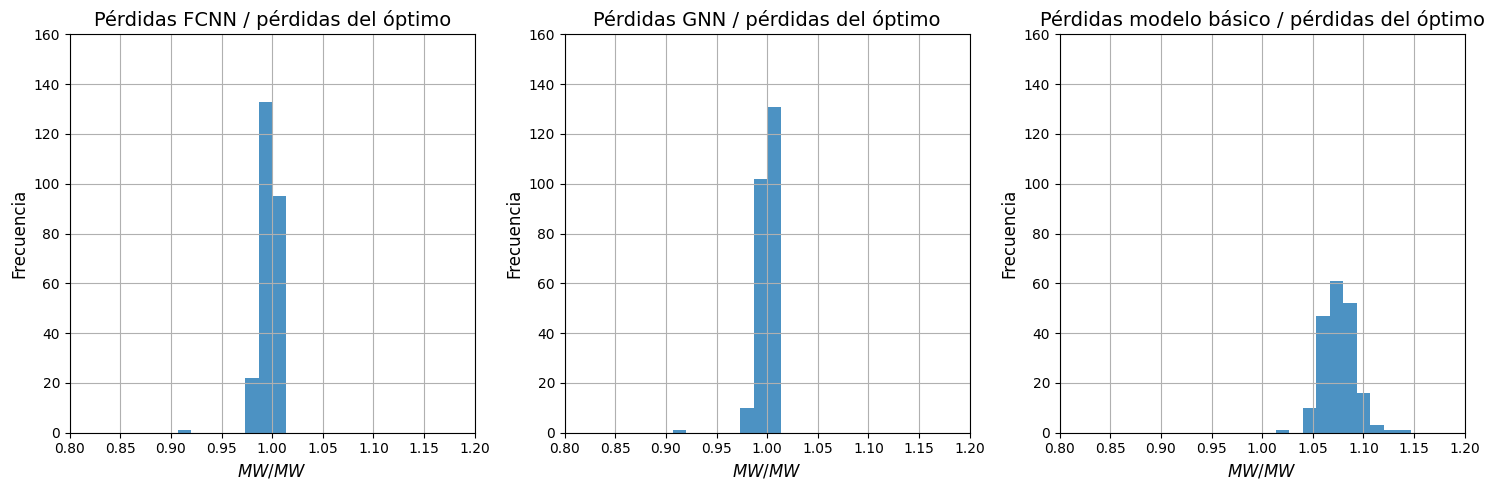

In [51]:
# 3 subplots with histograms
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(v_cost_hist_FCNN[unf_hist_FCNN == 0,0] / v_cost_hist_FCNN[unf_hist_FCNN == 0,1], bins=30, range=(0.8, 1.2),alpha=0.8, label='FCNN/opt')
axs[0].set_title("Pérdidas FCNN / pérdidas del óptimo",fontsize=14)
axs[0].grid()
axs[0].set_xlabel(r'$MW/MW$',fontsize=12)
axs[0].set_ylabel("Frecuencia",fontsize=12)
axs[0].set_xlim([0.8, 1.2])
axs[0].set_ylim([0, 160])
axs[1].hist(v_cost_hist_GNN[unf_hist_GNN == 0,0] / v_cost_hist_GNN[unf_hist_GNN == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, label='GNN/opt')
axs[1].set_title("Pérdidas GNN / pérdidas del óptimo",fontsize=14)
axs[1].grid()
axs[1].set_xlabel(r'$MW/MW$',fontsize=12)
axs[1].set_ylabel("Frecuencia",fontsize=12)
axs[1].set_xlim([0.8, 1.2])
axs[1].set_ylim([0, 160])
axs[2].hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, label='v1/opt')
axs[2].set_title("Pérdidas modelo básico / pérdidas del óptimo",fontsize=14)
axs[2].grid()
axs[2].set_xlabel(r'$MW/MW$',fontsize=12)
axs[2].set_ylabel("Frecuencia",fontsize=12)
axs[2].set_xlim([0.8, 1.2])
axs[2].set_ylim([0, 160])

plt.tight_layout()
plt.show()



El porcentaje de unfeasibles en el predecido es 0.2375, un total de 76
El porcentaje de unfeasibles en el optimo es 0.159375, un total de 51
El porcentaje de unfeasibles en el setpoint 1 es 0.4, un total de 128


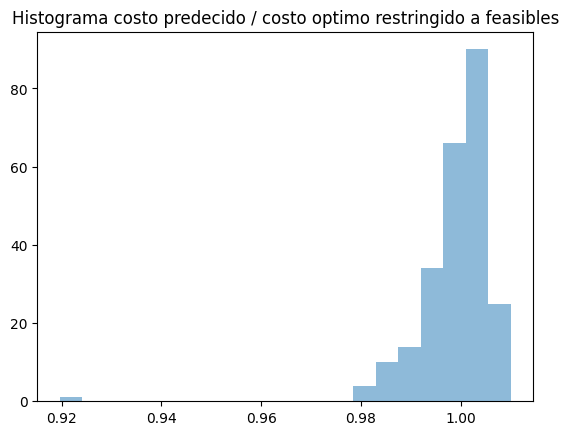

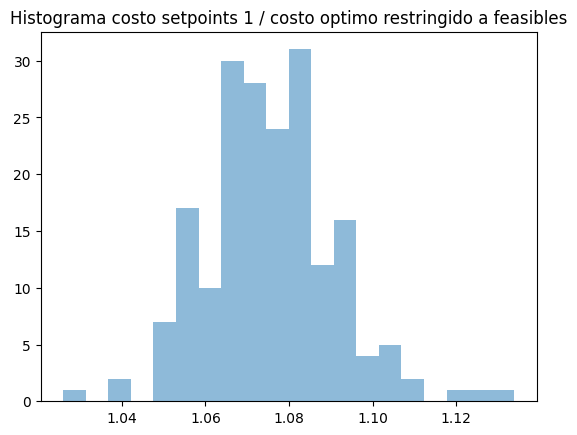

In [52]:
# FEASIBILITY

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}, un total de {np.sum(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}, un total de {np.sum(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}, un total de {np.sum(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [53]:
if arq == 'FCNN':
    gap_percentages_hist_FCNN = gap_percentages_hist_pred.copy()
else:
    gap_percentages_hist_GNN = gap_percentages_hist_pred.copy()
    


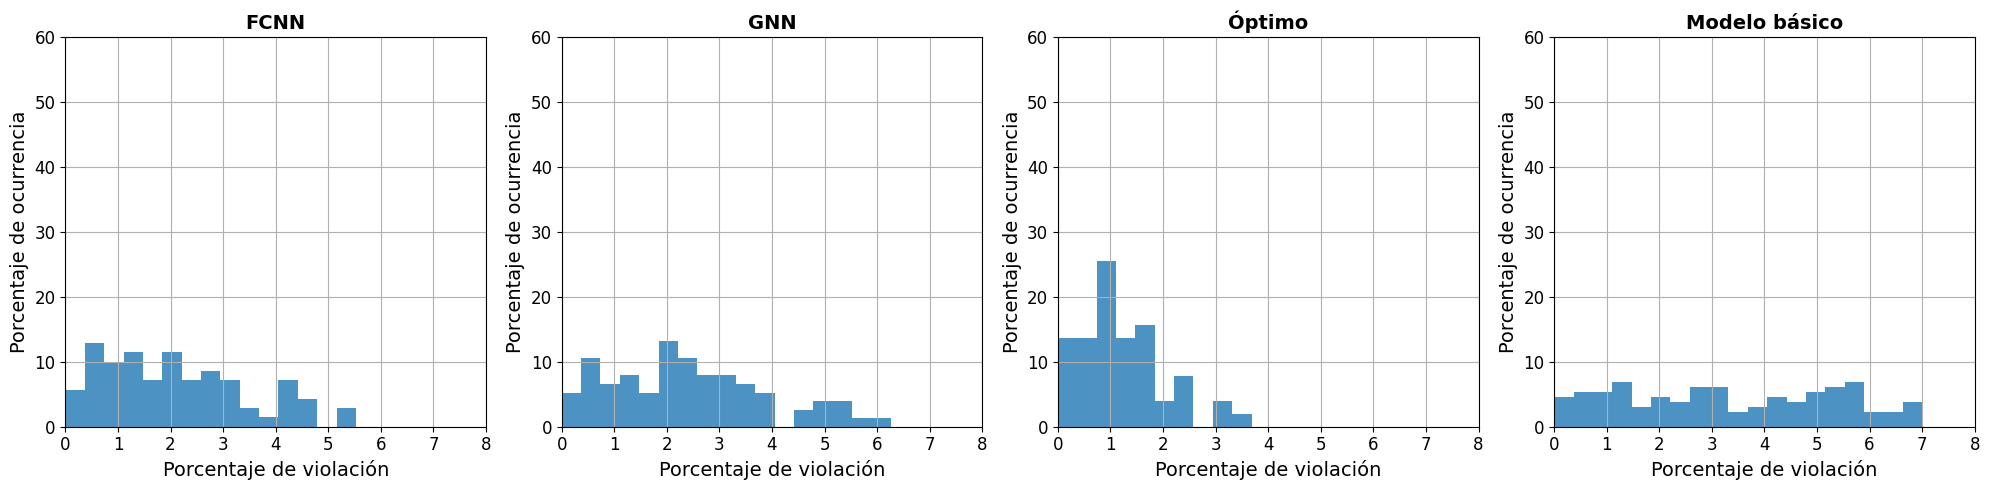

In [54]:
import matplotlib.pyplot as plt
# # Plot the normalized histogram for pred
# plt.title("Histograma de gaps en porcentaje para pred")
# plt.hist(gap_percentages_hist_pred, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

# # Plot the normalized histogram for opt
# plt.title("Histograma de gaps en porcentaje para opt")
# plt.hist(gap_percentages_hist_opt, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

bins = np.linspace(0, 7, 20)  # Creates 10 bins from 0 to 10

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Define consistent limits for the x and y axes
# x_limits = (0, 6.5)
# y_limits = (0, 36) 
x_limits = (0, 8)
y_limits = (0, 60)

# Plot the normalized histogram for pred FCNN
axs[0].set_title("FCNN", fontsize=14, fontweight='bold')
axs[0].hist(gap_percentages_hist_FCNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_FCNN) / len(gap_percentages_hist_FCNN) * 100)  
axs[0].set_xlabel("Porcentaje de violación", fontsize=14)
axs[0].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid()

# Plot the normalized histogram for pred GNN
axs[1].set_title("GNN", fontsize=14, fontweight='bold')
axs[1].hist(gap_percentages_hist_GNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_GNN) / len(gap_percentages_hist_GNN) * 100) 
axs[1].set_xlabel("Porcentaje de violación", fontsize=14)
axs[1].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid()

# Plot the normalized histogram for opt
axs[2].set_title("Óptimo", fontsize=14, fontweight='bold')
axs[2].hist(gap_percentages_hist_opt, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_opt) / len(gap_percentages_hist_opt) * 100)  
axs[2].set_xlabel("Porcentaje de violación", fontsize=14)
axs[2].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[2].grid()

# Plot the normalized histogram for v1
axs[3].set_title("Modelo básico", fontsize=14, fontweight='bold')
axs[3].hist(gap_percentages_hist_v1, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_v1) / len(gap_percentages_hist_v1) * 100)  
axs[3].set_xlabel("Porcentaje de violación", fontsize=14)
axs[3].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[3].set_xlim(x_limits)
axs[3].set_ylim(y_limits)
axs[3].tick_params(axis='both', which='major', labelsize=12)
axs[3].grid()

plt.tight_layout()
plt.show()


## Analiza Tiempo

In [34]:
import time 

ts = []
for x in test_loader:
    for dato in x:
        t_0 = time.time()
        _ = model(dato.unsqueeze(0)).detach().cpu().numpy()
        t_f = time.time()
        ts.append(t_f-t_0)

print(f"El tiempo por dato promedio para {arq}/IEEE{red} es {np.mean(ts)}")


El tiempo por dato promedio para FCNN/IEEE30 es 0.00043437480926513674


In [40]:
import time 

t_0 = time.time()
for x in test_loader:
        _ = model(x[0]).detach().cpu().numpy()
t_f = time.time()

print(f"El tiempo para todo el conjunto de test es de {t_f-t_0}")

El tiempo para todo el conjunto de test es de 0.005645275115966797


In [41]:
import time 
ts = []
net.line["pm_param/target_branch"] = True
pp.runpm_ploss(net)
for idx in range(np.shape(x_tot)[0]):
    t_0 = time.time()
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
    pp.runpm_ploss(net)
    t_f = time.time()
    ts.append(t_f-t_0)
    
print(f"El tiempo para el IPOPT para cada dato es {np.mean(ts)}")
print(f"El tiempo para el IPOPT para el conjunto de test es {np.sum(ts)}")

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

El tiempo para el IPOPT para cada dato es 0.10008395686745644
El tiempo para el IPOPT para el conjunto de test es 32.02686619758606
